In [6]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
import yt

import multiprocessing

nproc=multiprocessing.cpu_count()
print (nproc)

from matplotlib import font_manager 
font_manager.findfont('Times New Roman') 
#plt.rc('font', family='serif') 
plt.rc('font', serif='Times New Roman') 

hdir='/Users/gmurphy/Documents/results'
simdir='MRI-258-064+0-SPE_beta_y=1600,iso,OA/'
simdir='MRI-258-064+0-SPE_beta_z=1600,iso,OA,NVF=0.06/'
simdir='MRI-258-064+0-SPE_beta_z=1600,iso,OA/'


def readnirv(num, dir2) : 
    numstr=str(num)
    numstrlz=str(num).zfill(6)
    with h5py.File(dir2+'usr'+numstrlz+'.h5','r') as hf:
        print('List of arrays in this file: \n', hf.keys())
        dens = hf.get('density')
        den = np.array(dens)
        bh=hf.get('magnetic_field')   
        vh=hf.get('velocity')   
        b=bh.value
        v=vh.value
        rho=(np.squeeze(den[:,:,:] ))
        vx=(np.squeeze(v[:,:,:,0]))
        vy=(np.squeeze(v[:,:,:,1]))#-vy0
        vz=(np.squeeze(v[:,:,:,2]))
        bx=(np.squeeze(b[:,:,:,0]))
        by=(np.squeeze(b[:,:,:,1]))
        bz=(np.squeeze(b[:,:,:,2]))


        
    ds = dict(density = (den, "code_mass/code_length**3"), 
        velocity_x = (vx, "code_length/code_time"), 
        velocity_y = (vy, "code_length/code_time"), 
        velocity_z = (vz, "code_length/code_time"),
        b_x = (bx, "code_magnetic"),
        b_y = (by, "code_magnetic"),
        b_z = (bz, "code_magnetic")
     )
    bbox = np.array([[-1., 1.], [0., 5.], [-4, 4]])
    ds = yt.load_uniform_grid(ds, den.shape, length_unit="code_length", bbox=bbox, nprocs=nproc)
    return ds
    
    

#dir2='/astro/gmurphy/scratch/MRI-258-064+0-SPE_beta_z=1600,iso,OA/'

num=790000
dir2=hdir+'/'+simdir+'/'



8


yt : [INFO     ] 2016-02-29 10:00:46,999 Parameters: current_time              = 0.0
yt : [INFO     ] 2016-02-29 10:00:46,999 Parameters: domain_dimensions         = [129 321 513]
yt : [INFO     ] 2016-02-29 10:00:47,000 Parameters: domain_left_edge          = [-1.  0. -4.]
yt : [INFO     ] 2016-02-29 10:00:47,000 Parameters: domain_right_edge         = [ 1.  5.  4.]
yt : [INFO     ] 2016-02-29 10:00:47,001 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2016-02-29 10:00:56,310 AMRKDTree rebuilt, Final Volume: 8.000000e+01
Streamlining: 100%|██████████| 100/100 [00:02<00:00, 40.77it/s]

List of arrays in this file: 
 KeysViewWithLock(<HDF5 file "usr790000.h5" (mode r)>)


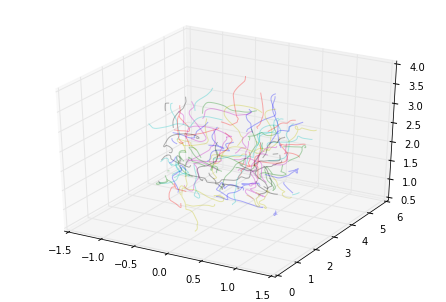

In [7]:
import yt
import numpy as np
import matplotlib.pylab as pl

from yt.visualization.api import Streamlines
from yt.units import Mpc
from mpl_toolkits.mplot3d import Axes3D


num=790000
dir2=hdir+'/'+simdir+'/'
ds = readnirv(num, dir2)

# Define c: the center of the box, N: the number of streamlines,
# scale: the spatial scale of the streamlines relative to the boxsize,
# and then pos: the random positions of the streamlines.
c = ds.domain_center
c[2]=c[2]+0.25*ds.domain_width[2]
N = 100
scale = ds.domain_width[0]
pos_dx = np.random.random((N,3))*scale-scale/2.
pos = c+pos_dx

# Create streamlines of the 3D vector velocity and integrate them through
# the box defined above
streamlines = Streamlines(ds, pos, 'b_x', 'b_y', 'b_z',
                          length=2.0, get_magnitude=True)
streamlines.integrate_through_volume()

# Create a 3D plot, trace the streamlines throught the 3D volume of the plot
fig=pl.figure()
ax = Axes3D(fig)
for stream in streamlines.streamlines:
    stream = stream[np.all(stream != 0.0, axis=1)]
    ax.plot3D(stream[:,0], stream[:,1], stream[:,2], alpha=0.3)

# Save the plot to disk.
pl.savefig('streamlines.png')

In [ ]:
import yt
import numpy as np
from yt.visualization.api import Streamlines
import matplotlib.pylab as pl
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Load the dataset
#ds = yt.load("IsolatedGalaxy/galaxy0030/galaxy0030")

# Define c: the center of the box, N: the number of streamlines,
# scale: the spatial scale of the streamlines relative to the boxsize,
# and then pos: the random positions of the streamlines.
c = ds.arr([0.5]*3, 'code_length')

#c = ds.domain_center
#c[2]=c[2]+0.25*ds.domain_width[2]
N = 30
scale = ds.quan(1, 'code_length').in_units('code_length')  # 15 kpc in code units
pos_dx = np.random.random((N,3))*scale-scale/2.
pos = c+pos_dx
 
# Create the streamlines from these positions with the velocity fields as the
# fields to be traced
streamlines = Streamlines(ds, pos, 'b_x', 'b_y', 'b_z', 
                          length=2.0, get_magnitude=True) 
streamlines.integrate_through_volume()

# Create a 3D matplotlib figure for visualizing the streamlines
fig=pl.figure() 
ax = Axes3D(fig)

# Trace the streamlines through the volume of the 3D figure
for stream in streamlines.streamlines:
    stream = stream[np.all(stream != 0.0, axis=1)]

    # Make the colors of each stream vary continuously from blue to red
    # from low-x to high-x of the stream start position (each color is R, G, B)
    # can omit and just set streamline colors to a fixed color
    x_start_pos = ds.arr(stream[0,0], 'code_length')
    x_start_pos -= ds.arr(0.5, 'code_length')
    x_start_pos /= scale 
    x_start_pos += 0.5
    color = np.array([x_start_pos, 0, 1-x_start_pos])

    # Plot the stream in 3D
    ax.plot3D(stream[:,0], stream[:,1], stream[:,2], alpha=0.3, color=color)

# Create a sphere object centered on the highest density point in the simulation
# with radius = 1 Mpc
sphere = ds.sphere(ds.domain_center)

# Identify the isodensity surface in this sphere with density = 1e-24 g/cm^3
surface = ds.surface(sphere, "density", 0.3)

# Color this isodensity surface according to the log of the temperature field
colors = yt.apply_colormap(surface["b_z"], cmap_name="hot")

# Render this surface 
p3dc = Poly3DCollection(surface.triangles, linewidth=0.0)
colors = colors[0,:,:]/255.  # scale to [0,1]
colors[:,3] = 0.3            # alpha = 0.3
p3dc.set_facecolors(colors)
ax.add_collection(p3dc)

# Save the figure
pl.savefig('streamlines_isocontour.png')